# 時系列データとは何か，その基本的な取り扱いについて調べる(2022/01/25)
---
## 概要
---
データの形式の一つである時系列データについて，その特性・分析手法(トレンド，周期性，ノイズ，移動平均，季節調整，階差，スペクトル，自己相関，相互相関，自己回帰モデル)について調べる．

## 時系列データ
---
時系列データとは，時間の経過とともに変化する量を等間隔で記録したデータのことである．例えば，毎日測定する体重の推移であるとか，株価，商品の売り上げ，気温，そして今回例として使用するGDPの推移に至るまで，時系列データは様々な事象から得られるものである．昨今話題となっている新型コロナウイルス感染症患者数の推移も時系列データの一種である．

時系列データはその性質ゆえ，グラフにプロットされる際は横軸が時間軸，そして縦軸が当該データの特徴量になることが多い．時間軸のスケールは扱うデータの性質によってさまざまで，一秒おきに得られるデータもあれば，数年おきに得られるデータもある．

このnotebookでは四半期ごとに収集されていた日本国の実質GDPを例として，時系列データに対する分析の切り口を学ぶ．

早速，内閣府が公表している実質GDPのデータをpandas DataFrameに読み込んでいく．

In [1]:
import pandas as pd

gdp_jp = pd.read_excel('gdp_jp_2021.xlsx',
                       header=None,
                       skiprows=7,
                       names=['y/m', 'GDP'],
                       index_col=[0],
                       usecols=[0, 1])
gdp_jp.dropna(inplace=True)
gdp_jp

,GDP
y/m,
1994/ 1- 3.,109110.2
4- 6.,107756.4
7- 9.,112077.0
10-12.,117578.7
1995/ 1- 3.,110520.9
...,...
7- 9.,130613.2
10-12.,138078.0
2021/ 1- 3.,135013.1


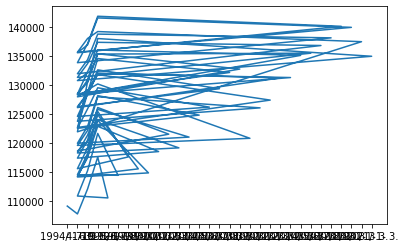

In [2]:
# このままの状態でプロットできるかと思ったが，インデックスの月が重複していてうまくできない
import matplotlib.pyplot as plt 

plt.plot(gdp_jp)

In [3]:
# 【修正】全てのインデックスに年を振る

pd.period_range(start='1994Q1', end='2021Q3', freq='Q-DEC')

PeriodIndex(['1994Q1', '1994Q2', '1994Q3', '1994Q4', '1995Q1', '1995Q2',
             '1995Q3', '1995Q4', '1996Q1', '1996Q2',
             ...
             '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3',
             '2020Q4', '2021Q1', '2021Q2', '2021Q3'],
            dtype='period[Q-DEC]', length=111)

In [4]:
index = pd.period_range(start='1994Q1', end='2021Q3', freq='Q-DEC')
gdp_jp.index = index
gdp_jp

,GDP
1994Q1,109110.2
1994Q2,107756.4
1994Q3,112077.0
1994Q4,117578.7
1995Q1,110520.9
...,...
2020Q3,130613.2
2020Q4,138078.0
2021Q1,135013.1
2021Q2,130811.5


<AxesSubplot:title={'center':'GDP(Expenditure Approach)'}>

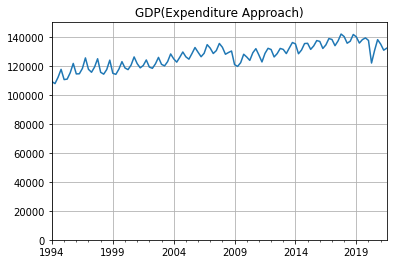

In [5]:
# インデックスを修正したところで，再度プロット
gdp_jp.GDP.plot(title='GDP(Expenditure Approach)', grid=True, ylim=(0, 150000))

### トレンド
時系列データにおけるトレンドは，長期的な視点で見た際にデータ全体の傾向を指す言葉として使われる．例えば，用意したGDPデータにおけるトレンドは，「おおむね上昇傾向にある」と言うことができる．

トレンドを視覚から直感的に把握する方法として，移動平均が挙げられる．移動平均は一定期間の時系列データの平均値を算出することであり，短期間の変化に寄らない値の傾向をとらえることができる．

移動平均をとる際の期間は「窓幅」「項数」などと呼ばれる．窓幅を広くとれば，より滑らかなグラフを描画でき，時系列データのトレンドをとらえやすくなる．

実際にGDPのデータを用いて移動平均を算出し，増加傾向を可視化してみる．

<AxesSubplot:title={'center':'GDP(Expenditure Approach)'}>

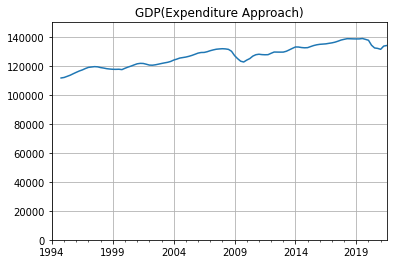

In [6]:
# 窓幅4で移動平均を算出し，結果をプロット
gdp_jp.GDP.rolling(4).mean().plot(title='GDP(Expenditure Approach)', grid=True, ylim=(0, 150000))

<AxesSubplot:title={'center':'GDP(Expenditure Approach)'}>

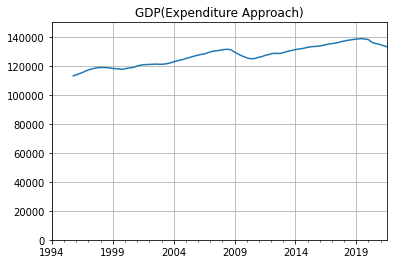

In [7]:
# 窓幅8で移動平均を算出し，結果をプロット
# 窓幅を増やすと，グラフはより滑らかになる
gdp_jp.GDP.rolling(8).mean().plot(title='GDP(Expenditure Approach)', grid=True, ylim=(0, 150000))

移動平均を用いることで，全体的に右肩上がりのトレンドが見えるほか，2009年頃(リーマンショック)や2020年頃(新型コロナウイルス感染症拡大)に発生している減少傾向も発見することができた．

### 周期性
時系列データで見ることのできる特徴として，トレンドの他に周期性というものがある．これはその名の通り，一定期間で周期的に値が変動する性質を指す．

今回用いるGDPのデータの場合は，トレンドとは別に年度ごとにギザギザとした山が現れている様子が確認できる．このように，年を周期として現れる周期性を，季節による変化だと捉えて「季節性」「季節変動」と呼ぶこともある．

長期にわたる値の変動ではなく，周期性のように短期的な値の増減を分析したい場合には，データの階差をとるという方法がある．階差とは一定期間前のデータとの差分のことである．

例えば，季節変動を除去することを季節調整と呼ぶが，それを階差によって実現する場合は一年前の同時期のデータとの差を計算すればよい．

今回はGDPを例として階差を計算し，短期的なデータの傾向を見ることにする．

<AxesSubplot:title={'center':'GDP(difference=1)'}>

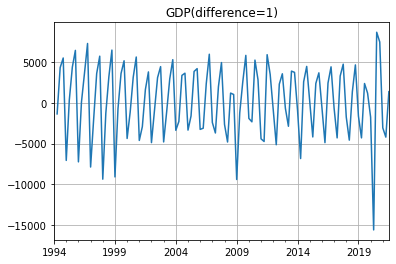

In [8]:
# 前後の四半期で階差を取り，プロットする
gdp_jp.GDP.diff().plot(title='GDP(difference=1)', grid=True)

前後の期間で階差を取ることで，線形性のあったトレンドを除去し，周期的なデータの増減が可視化できた．

蛇足だが，階差の階差を取ることで，データの二次関数的な増減を除去することができる．

<AxesSubplot:title={'center':'GDP(difference=4)'}>

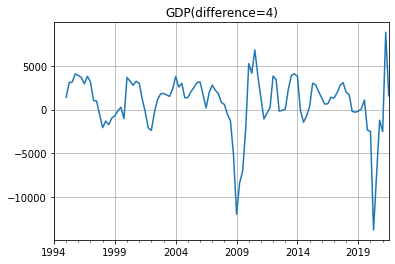

In [9]:
# 今度は一年前の同時期のデータとの階差を取ることで，季節変動を除去する
gdp_jp.GDP.diff(4).plot(title='GDP(difference=4)', grid=True)

季節調整を行ったことで，年毎のギザギザとした季節変動がなくなり，2009年と2020年あたりのGDPの減少がハッキリと見えるようになった．

### ノイズ
ノイズは分野によっても様々な説明がある．時系列データの解析においては「分析に必要ではない値の増減」といったニュアンスが適当かもしれない．

例えば先のGDP分析の場合は，トレンドを把握しようとしているときに季節変動はノイズになる．対して，周期性(季節変動)をとらえようとしている時に，トレンドはノイズだとみなせる．

また時系列データの場合，トレンドによるものでもなく，周期性のある変動でもない値の変動が起こりうる．これをノイズとみなすこともある．これこそ完全な「雑音」だと言えるかもしれない．

## 時系列データの分析
---
本節では，移動平均や階差とは別に，時系列データの性質を明らかにするための分析方法について説明する．具体的には，以下の3つである．

1. 自己相関
1. 相互相関
1. 自己回帰モデル

このうち自己回帰モデルについては，手元にあるデータを解析するというより，手元にあるデータから将来のデータのふるまいを予測するという意味合いが強い．

### 自己相関
自己相関とはその名の通り，ひとつの時系列データ内で相関を計算することで求められる指標である．

具体的には，得られた時系列データと$k$ステップ前の時系列データとで相関係数を計算する：

\begin{eqnarray}
R(k) = Corr(x_n, x_{n-k})
\end{eqnarray}

つまり，時系列データを$k$だけ「ずらしながら」相関係数を逐次的に計算していくことになる．$k=0$の場合は同時刻の時系列データを用いているので，当然相関係数は1になる．

$R(k)$は自己相関関数と呼ばれ，横軸に$k$を取ることで時系列データの周期性を把握するのに役立つ．

ここでもGDPのデータを例として，自己相関関数のグラフを描画してみる．

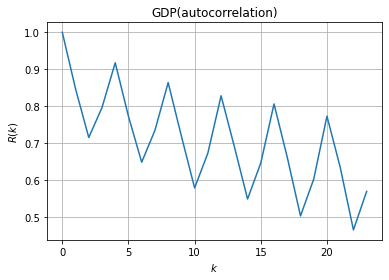

In [10]:
# 自己相関の計算
k = 24
gdp_autocorrelation = [] 
for i in range(k):
    gdp_autocorrelation.append(gdp_jp['GDP'].autocorr(lag=i))

plt.title('GDP(autocorrelation)')
plt.xlabel('$k$')
plt.ylabel('$R(k)$')
plt.grid()
plt.plot(gdp_autocorrelation)

四周期(一年)ごとに相関が強くなっていることから，季節変動の様子が確認できる．

期間が離れれば離れるほど相関がなくなる傾向もみられる．

### 相互相関
相互相関とは，2つ以上の時系列データ同士の相関係数のことである．

例えば，2つの変数$x(i), x(j)$があるとき，相互相関関数は以下のように定義される：

\begin{eqnarray}
R_k(i,j) = Corr(x_n(i), x_{n-k}(j)) 
\end{eqnarray}

つまり，自己相関関数をより一般化した形だといえる．$i=j$のとき，自己相関に等しくなる．

また，m個の変数について相互相関関数を求め，行列形式でプロットすると時系列データ間の相関関係が一覧できる．

今回はGDPデータとの相互相関を計算する時系列データとして，日本の実質平均給与を参照する．

In [11]:
# 平均給与データの読み込み
salary_jpn = pd.read_excel('salary_jpn.xls',
                           header=None,
                           skiprows=4,
                           index_col=0,
                          usecols=[0,1],
                          names=['year', 'salary_jpn'])

salary_jpn.dropna(inplace=True)
salary_jpn.index = pd.period_range(start=1989, end=2018, freq='Y')
salary_jpn

,salary_jpn
1989,452.134831
1990,463.685932
1991,471.097046
1992,472.481828
1993,464.271047
1994,465.270684
1995,468.442623
1996,472.131148
1997,471.068548
1998,465.265265


<AxesSubplot:title={'center':'japan salary'}, xlabel='year', ylabel='ten thousand yen'>

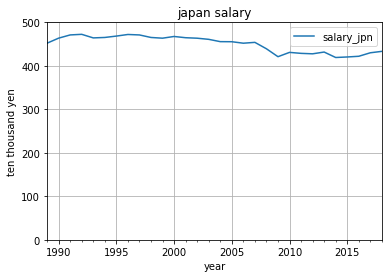

In [12]:
salary_jpn.plot(title='japan salary',
                xlabel='year',
                ylabel='ten thousand yen',
                ylim=[0,500],
                grid=True)

トレンドは減少傾向...なのはさておき，GDPとの共通範囲である1994年から2018年の間を用いて相互相関を求めてみる．また，GDPは四半期ごとに算出されているため，年毎の平均値を求めて使用する．

In [13]:
# GDPの年毎の平均値を算出
gdp_jp_year = gdp_jp.resample('Y').mean()
gdp_jp_year['1994':'2018']

,GDP
1994,111630.575
1995,114567.550
1996,118157.975
1997,119317.375
1998,117801.650
1999,117408.250
2000,120654.200
2001,121120.075
2002,121170.850
2003,123031.025


In [14]:
# corrwithは列名をそろえないと相関係数を計算してくれない
# 列名が異なる場合には，片方をSeriesにする工夫が必要
corr = gdp_jp_year['1994':'2018'].corrwith(salary_jpn.loc['1994':'2018','salary_jpn'])
corr

GDP   -0.772951
dtype: float64

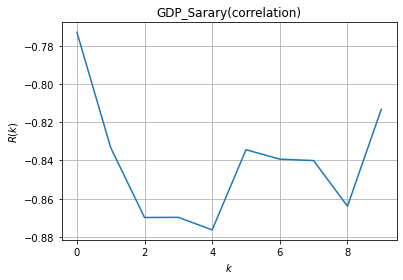

In [15]:
# 相互相関関数の値を算出してプロット
k = 10
gdp_salary_correlation = [] 
for i in range(k):
    gdp_salary_correlation.append(gdp_jp_year.loc['1994':'2018','GDP'].shift(i).corr(salary_jpn.loc['1994':'2018','salary_jpn']))

plt.title('GDP_Sarary(correlation)')
plt.xlabel('$k$')
plt.ylabel('$R(k)$')
plt.grid()
plt.plot(gdp_salary_correlation)

本来であれば多変量時系列データ間の周期性を観測できれば良かったが，今回用いたデータは量が少なく十分な規則性は把握できなかった．

ただ，一応GDPと平均給与との間に負の相関が見られることは確かめられた．経済学に疎い素人目からすると，GDPが上昇すれば平均給与も上がりそうなものだが，どうなのだろうか．

### 自己回帰モデル
自己回帰モデルはその名の通り，既に手元にある時系列データを利用して将来の推移を予測する回帰モデルのことである．言い換えると，過去のデータをもとにして未来のデータを予測するモデルを構築するということになる．

具体的には，ある時刻$t$までのデータを用いて，未だ観測できない未来の時刻$t+1$のデータを予測することを考えるとき，その値は以下のように表される：

\begin{eqnarray}
x_{t+1} = a_1x_t + a_2x_{t-1} + ... + a_kx_{t+1-k} + v
\end{eqnarray}

$\{a_1,...,a_k\}$は定数であり，このモデルの予測精度に関わるパラメータである．このパラメータを推定する方法はいくつかあるが，また別の機会に自己回帰モデルの派生形も含めて扱おうと思う．なお，係数パラメータの数$k$を増やすほど過去の情報をモデルが利用することになり，一般的に精度は向上する．

また，$v$は予測誤差と呼ばれるノイズ項であり，$v \sim N(0, \sigma^2)$と仮定する．

## 参考文献

[時系列，Wikipedia](https://ja.wikipedia.org/wiki/%E6%99%82%E7%B3%BB%E5%88%97)

[時系列データの解析，東京大学　数理・情報教育研究センター](http://www.mi.u-tokyo.ac.jp/consortium2/pdf/4-4_literacy_level_note.pdf)

[32-3. 時系列データと移動平均，統計WEB](https://bellcurve.jp/statistics/course/12933.html)

[32-4. 時系列データにおける周期変動，統計WEB](https://bellcurve.jp/statistics/course/23739.html)

[32-5. 自己相関，統計WEB](https://bellcurve.jp/statistics/course/12935.html)

[【テックコラム】時系列データの基礎と可視化，DataCurrent](https://www.datacurrent.co.jp/column/time-series-visualization20210628/)

[時系列相関，株式会社アイスタット](https://istat.co.jp/ji_commentary/time_series)

[統計表一覧(2021年 7-9月期 2次速報値)，内閣府](https://www.esri.cao.go.jp/jp/sna/data/data_list/sokuhou/files/2021/qe213_2/gdemenuja.html)

[pandas.read_excel，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html)

[pandas.DataFrame.dropna，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)

[pandas.period_range，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.period_range.html)

[pandas.DataFrame.plot，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

[pandas.DataFrame.diff，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html)

[pandas.Series.autocorr，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.autocorr.html)

[図表1-8-2　平均給与（実質）の推移（1年を通じて勤務した給与所得者），厚生労働省](https://www.mhlw.go.jp/stf/wp/hakusyo/kousei/19/backdata/01-01-08-02.html)

[pandas.DataFrame.resample，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)

[pandas.DataFrame.corrwith，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html#pandas.DataFrame.corrwith)

[Pythonのpd.corrwithの使い方について（Series型とDataFrame型の違い），teratail](https://teratail.com/questions/211241)

[pandas.Series.shift，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.shift.html)

[pandas.Series.corr，pandas 1.4.0 documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.corr.html)

https://stats.biopapyrus.jp/time-series/ar-model.html#:~:text=%E8%87%AA%E5%B7%B1%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB%EF%BC%88AR%20%E3%83%A2%E3%83%87%E3%83%AB,%E3%83%A2%E3%83%87%E3%83%AA%E3%83%B3%E3%82%B0%E3%81%AB%E6%9C%89%E5%8A%B9%E3%81%A7%E3%81%82%E3%82%8B%E3%80%82

https://ja.wikipedia.org/wiki/%E8%87%AA%E5%B7%B1%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB

https://ai-trend.jp/basic-study/time-series-analysis/time-series-analysis-armodel/

https://ai-trend.jp/basic-study/time-series-analysis/time-series-analysis-armodel_stats/

https://www.mnc.toho-u.ac.jp/v-lab/yobology/AR_model/AR_model.htm

http://www.aoni.waseda.jp/abek/document/regression-6.html